In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import pandas_market_calendars as mcal
import datetime
import math

In [2]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3600) #10 years analysis
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

#S&P 500 ticker
SnP_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

def final_ticker(T_list):
    return list(set(T_list))

index_banch_mart = ["SPY"]

tickers = final_ticker(SnP_componet_ticker)
def Get_Average_price(tickers, start_date):
    data = yf.download(tickers,start = start_date)
    print('Removing ticker with nan values')
    data = data.dropna(axis=1, how='any')
    print('Calculating average price')
    data = (data['Open'] + data['Close'] + data['High'] + data['Low']) / 4
    return data

df = Get_Average_price(tickers,valid_start_day)
df_BM = yf.download(index_banch_mart,start = valid_start_day)["Open"]
number_of_stocks = df.shape[1]

[**********************90%%*****************     ]  452 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2015-01-14 -> 2024-11-22)


[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2015-01-14 -> 2024-11-22)')


Removing ticker with nan values
Calculating average price


[*********************100%%**********************]  1 of 1 completed


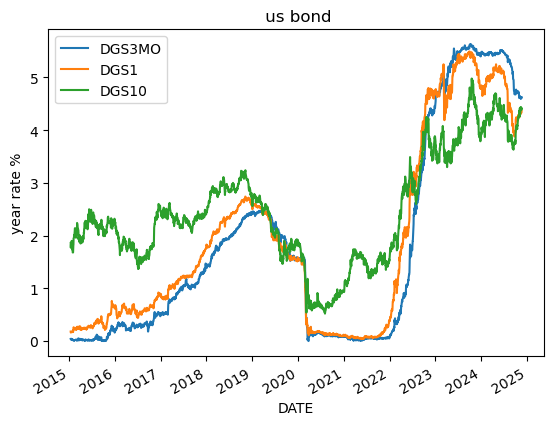

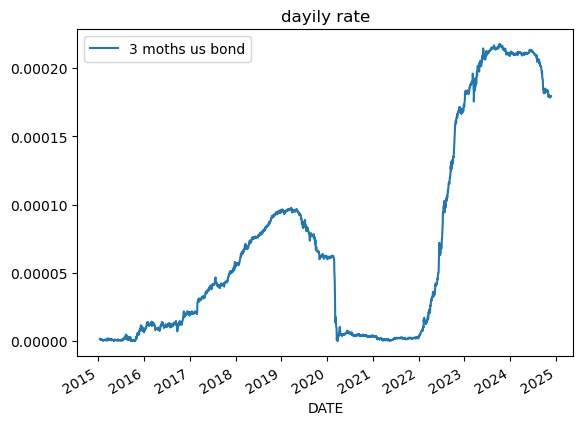

In [3]:
US_TB = ['DGS3MO', 'DGS1', 'DGS10'] #3 months, 1 year, 10 years

df_bonds = pdr.DataReader(US_TB, 'fred', valid_start_day, valid_end_day).dropna()
df_bonds["3month_cts_rate"] = (1+df_bonds["DGS3MO"]/100)**(1/252) -1 
risk_free_rate = df_bonds["3month_cts_rate"]

df_bonds["DGS3MO"].plot(title = " us bond", ylabel="year rate %")
#df_bonds["3month_cts_rate"].plot()
df_bonds["DGS1"].plot( )
df_bonds["DGS10"].plot( )
plt.legend()
plt.show()

risk_free_rate.plot(label = "3 moths us bond", title="dayily rate")
#df_bonds["3month_cts_rate"].plot()
plt.legend()
plt.show()

In [4]:
ret_df = np.log(df/df.shift(1)).dropna()
ret_df_BM = np.log(df_BM/df_BM.shift(1)).dropna()

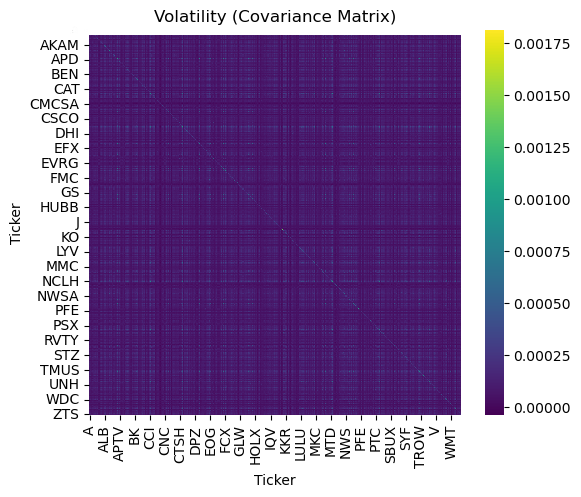

In [5]:
Covarian_matrix = ret_df.cov()
plt.figure(figsize=(6, 5))
sns.heatmap(Covarian_matrix, annot=True, cmap='viridis', fmt='.2e')
plt.title('Volatility (Covariance Matrix)')
plt.show()

Optimization Time

In [7]:
def Sharpe_pf(Weight,return_df,risk_free_rate):
    pf_risk = np.sqrt(Weight.dot(return_df.cov().dot(Weight)))
    pf_mean = return_df.mean().dot(Weight)
    if type(risk_free_rate) != int:
        risk_free_rate = risk_free_rate.mean()
    return -(pf_mean-risk_free_rate)/pf_risk

def Sortino_pf(Weight, return_df, benchmark_df):
    pf_return = return_df.dot(Weight)
    
    if isinstance(benchmark_df, (int, float)): # you can use an ETF or just the rfr
        benchmark_return = benchmark_df
    else:
        benchmark_return = benchmark_df.mean()
    
    downside_deviation = np.sqrt(
        np.mean(
            np.minimum(0, pf_return - benchmark_return) ** 2
        )
    )
    pf_mean = pf_return.mean()
    
    if downside_deviation == 0:
        return np.inf if pf_mean > benchmark_return else -np.inf
    return -(pf_mean - benchmark_return) / downside_deviation

def Ulcer_pf(Weight, return_df, risk_free_rate):
    cumulative_returns = (1 + return_df.dot(Weight)).cumprod()

    max_cumulative_returns = cumulative_returns.cummax()
    
    drawdowns = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns * 100
    
    ulcer_index = np.sqrt(np.mean(drawdowns ** 2))
    
    return ulcer_index

In [8]:
def Expected_return(Weight,return_df):
    return return_df.dot(Weight).cumsum().dropna()

In [9]:
T_fraction = 0.92 # ( 11/12, hold 1 month)
def split_train_test(df,BM,rfr,Fraction):
    def Log_return(df):
        return np.log(df/df.shift(1)).dropna()
    
    common_indices = df.index.intersection(rfr.index)
    df = df.loc[common_indices]
    common_indices = BM.index.intersection(rfr.index)

    df = df.loc[common_indices]
    rfr = rfr.loc[common_indices]
    BM = BM.loc[common_indices]

    matched_len = len(df)
    Train_len = int(matched_len*Fraction)
    
    train = Log_return(df[:Train_len])
    test = Log_return(df[Train_len:])
    rfr = np.log((1+rfr)) #Risk-Free Return (Log)
    
    BM_train = Log_return(BM[:Train_len])
    BM_test = Log_return(BM[Train_len:])

    rfr_train = rfr[:Train_len]
    rfr_test = rfr[Train_len:]

    return train, BM_train, rfr_train, test, BM_test, rfr_test 

Train, BM_train, Train_rfr, Test, BM_test, Test_rfr = split_train_test(df, df_BM, risk_free_rate, T_fraction)
BM = pd.concat([BM_train,BM_test])

In [10]:
def Fit_weight(method,N_stock,log_return,rfr):
    W_int = np.ones(N_stock)/N_stock
    cons = ({"type":"eq", "fun":lambda x:np.sum(x) - 1})
    
    Train_result = minimize(method,W_int,args=(log_return,rfr), bounds=Bounds(0,1),constraints = cons)
    W_opt_train = Train_result["x"]
    return W_opt_train

In [11]:
W_sharpe_ratio_train = Fit_weight(Sharpe_pf,number_of_stocks,Train,Train_rfr)
W_Sortino_ratio_train = Fit_weight(Sortino_pf,number_of_stocks,Train,BM_train)
W_Ulcer_index_train = Fit_weight(Ulcer_pf,number_of_stocks,Train,Train_rfr)
W_0 = np.ones(number_of_stocks)/number_of_stocks

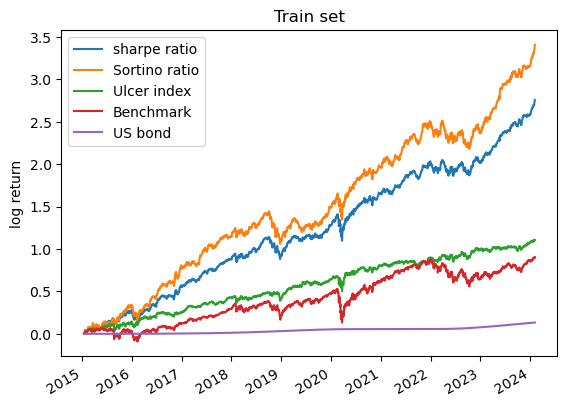

In [12]:
ER_sharp_ratio_train  = Expected_return(W_sharpe_ratio_train,Train)
ER_Sortino_ratio_train  = Expected_return(W_Sortino_ratio_train,Train)
ER_Ulcer_index_train  = Expected_return(W_Ulcer_index_train,Train)

ER_sharp_ratio_train.plot(title="Train set",ylabel="log return",label="sharpe ratio")
ER_Sortino_ratio_train.plot(label="Sortino ratio")
ER_Ulcer_index_train.plot(label="Ulcer index")
BM_train.cumsum().plot(label="Benchmark")
Train_rfr.cumsum().plot(label="US bond")
plt.legend()
plt.show()

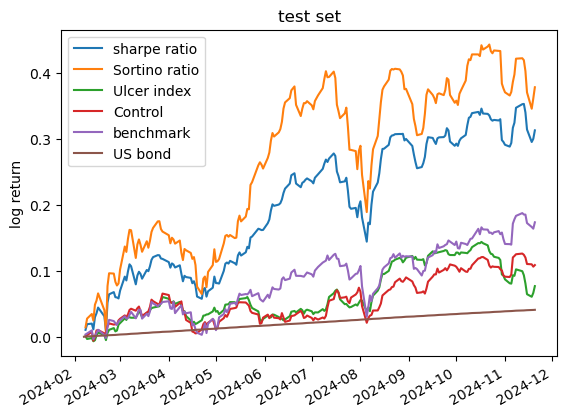

In [13]:
ER_sharpe_ratio_Test  = Expected_return(W_sharpe_ratio_train,Test)
ER_Sortino_ratio_Test  = Expected_return(W_Sortino_ratio_train,Test)
ER_Ulcer_index_Test  = Expected_return(W_Ulcer_index_train,Test)

ER_sharpe_ratio_final = ER_sharpe_ratio_Test.iloc[-1]
ER_Sortino_ratio_final = ER_Sortino_ratio_Test.iloc[-1]
ER_Ulcer_index_final = ER_Ulcer_index_Test.iloc[-1]


ER_control = Expected_return(W_0,Test)
ER_control_final = ER_control.iloc[-1]

BM_cumsum_final = BM_test.cumsum().iloc[-1]

ER_sharpe_ratio_Test.plot(title="test set",ylabel="log return",label="sharpe ratio")
ER_Sortino_ratio_Test.plot(label="Sortino ratio")
ER_Ulcer_index_Test.plot(label="Ulcer index")

ER_control.plot(label="Control")
BM_test.cumsum().plot(label="benchmark")
((1+Test_rfr).cumprod()-1).plot(label="US bond")
plt.legend()
plt.show()

In [14]:
print('Return for the test data are:')

print(f'Sharpe ratio: {np.exp(ER_sharpe_ratio_final):.2f}%')
print(f'Sortine ratio: {np.exp(ER_Sortino_ratio_final):.2f}%')
print(f'Ulcer index: {np.exp(ER_Ulcer_index_final):.2f}%')
print(f"Control return: {np.exp(ER_control_final):.2f}%")

print(f"Benchmark return is {BM_cumsum_final*100:.2f}%")
print(f"US bond return is {Test_rfr.iloc[-1]*100:2f}%")

Return for the test data are:
Sharpe ratio: 1.37%
Sortine ratio: 1.46%
Ulcer index: 1.08%
Control return: 1.11%
Benchmark return is 17.36%
US bond return is 0.017922%


In [15]:
def What_Should_I_buy(Ticker,Weight):
    buy_list = {}
    lower_limit = 0.01
    Weight_adj = [X if X >= lower_limit else 0 for X in Weight]
    Weight_og = Weight_adj
    Weight_adj = 1/sum(Weight_adj)*np.array(Weight_adj)
    
    print(f"The threshold is {lower_limit}")
    print("you should buy:")
    
    for T, W in zip(Ticker, Weight_adj):
        if W > lower_limit:
            buy_list[T] = W
            print(f"W_{T} =  {W:.2f}")
    print("------------------------------")
    print(f"Sum to {sum(Weight_og)}")
    print("==============================")
    return buy_list

print("For the test set")
print("==============================")
print('Sharpe ratio:')
Test_buy_list_sharpe_ratio = What_Should_I_buy(tickers,W_sharpe_ratio_train)
print('Sortino ratio:')
Test_buy_list_Sortino_ratio = What_Should_I_buy(tickers,W_Sortino_ratio_train)
print('Ulcer index:')
Test_buy_list_Sortino_ratio = What_Should_I_buy(tickers,W_Ulcer_index_train)


For the test set
Sharpe ratio:
The threshold is 0.01
you should buy:
W_BMY =  0.01
W_JNJ =  0.03
W_NI =  0.03
W_GRMN =  0.04
W_COF =  0.10
W_VZ =  0.28
W_DHR =  0.20
W_CL =  0.03
W_NFLX =  0.19
W_BSX =  0.06
W_ADP =  0.02
------------------------------
Sum to 0.9906330827100172
Sortino ratio:
The threshold is 0.01
you should buy:
W_COF =  0.09
W_VZ =  0.39
W_DHR =  0.40
W_NFLX =  0.10
W_MCD =  0.02
------------------------------
Sum to 0.9941943024771712
Ulcer index:
The threshold is 0.01
you should buy:
W_XYL =  0.05
W_HAL =  0.07
W_BEN =  0.05
W_DRI =  0.02
W_HWM =  0.02
W_HOLX =  0.02
W_EXPD =  0.07
W_VTR =  0.03
W_VZ =  0.14
W_JBL =  0.03
W_TAP =  0.08
W_BALL =  0.02
W_DG =  0.02
W_APA =  0.10
W_NFLX =  0.13
W_JCI =  0.02
W_PLTR =  0.04
W_MCD =  0.02
W_CSX =  0.04
W_ADP =  0.01
W_ROL =  0.03
------------------------------
Sum to 0.9733758380324107


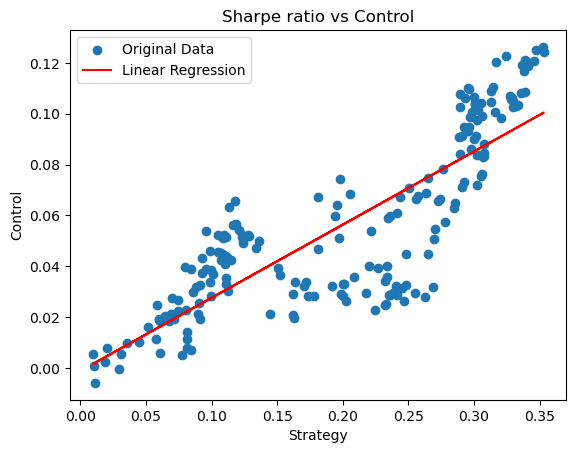

alpha and beta are -0.001, 0.288


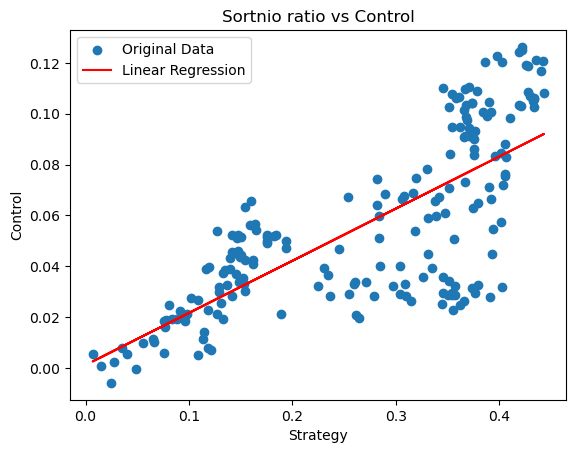

alpha and beta are 0.001, 0.205


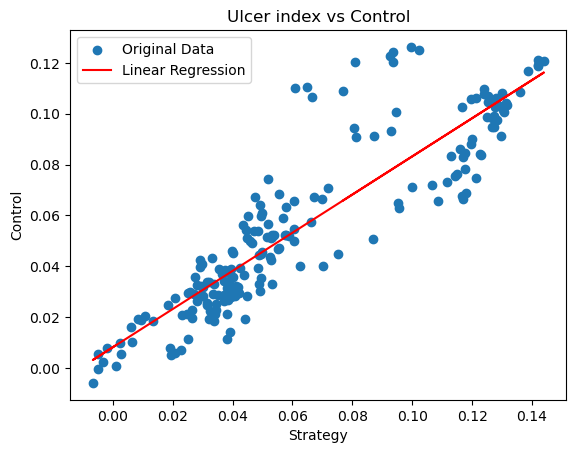

alpha and beta are 0.008, 0.751


In [16]:
import Functions.AlphaBeta as MT
plt.title("Sharpe ratio vs Control")
alpha, beta = MT.AlphaBeta(ER_sharpe_ratio_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Sortnio ratio vs Control")
alpha, beta = MT.AlphaBeta(ER_Sortino_ratio_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Ulcer index vs Control")
alpha, beta = MT.AlphaBeta(ER_Ulcer_index_Test.to_list(),ER_control.to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")


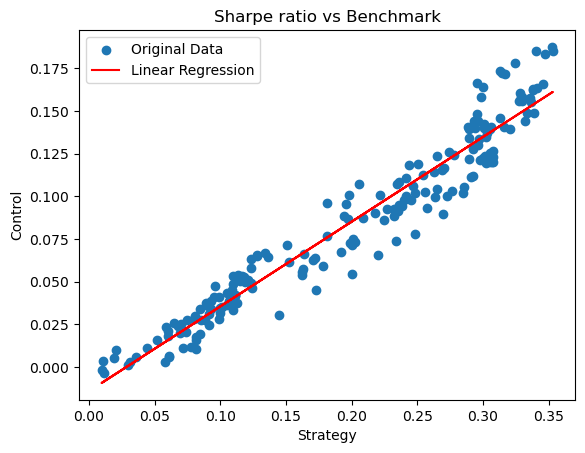

alpha and beta are -0.014, 0.497


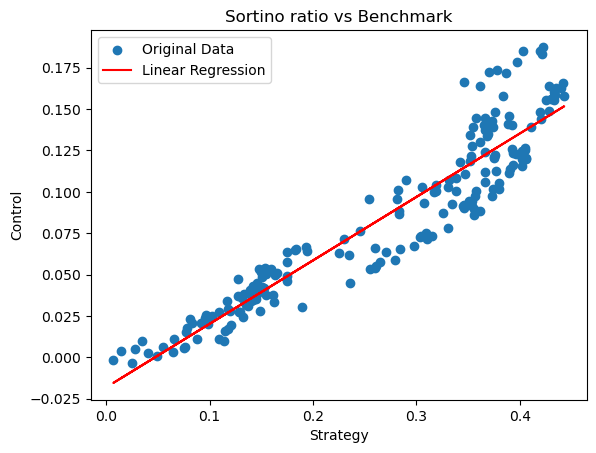

alpha and beta are -0.018, 0.383


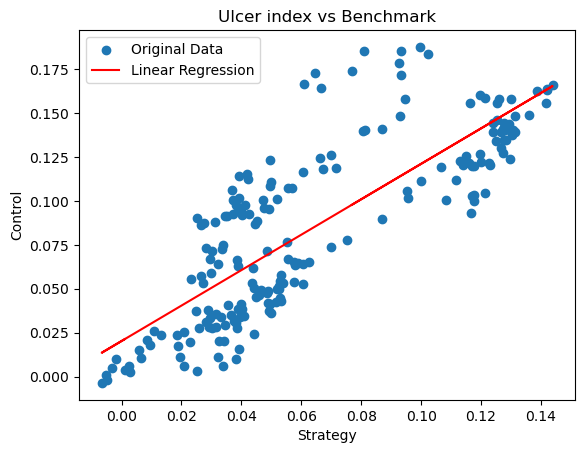

alpha and beta are 0.02, 1.008


In [17]:
plt.title("Sharpe ratio vs Benchmark")
alpha, beta = MT.AlphaBeta(ER_sharpe_ratio_Test.to_list(),BM_test.cumsum().to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Sortino ratio vs Benchmark")
alpha, beta = MT.AlphaBeta(ER_Sortino_ratio_Test.to_list(),BM_test.cumsum().to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

plt.title("Ulcer index vs Benchmark")
alpha, beta = MT.AlphaBeta(ER_Ulcer_index_Test.to_list(),BM_test.cumsum().to_list(),0,plot=True)
print(f"alpha and beta are {alpha}, {beta}")

In [18]:
#W_sharpe_ratio_final = Fit_weight(Sharpe_pf,number_of_stocks,ret_df,np.log(risk_free_rate))
W_Sortino_ratio_final = Fit_weight(Sortino_pf,number_of_stocks,ret_df,BM)
#W_Ulcer_index_final = Fit_weight(Ulcer_pf,number_of_stocks,ret_df,np.log(risk_free_rate))

In [19]:
print("==============================")
print('Sortino ratio:')
Buy_list_Sortino_ratio = What_Should_I_buy(tickers,W_Sortino_ratio_final)

Sortino ratio:
The threshold is 0.01
you should buy:
W_COF =  0.21
W_VZ =  0.19
W_DHR =  0.40
W_NFLX =  0.20
------------------------------
Sum to 1.0000000000000033


['COF', 'VZ', 'DHR', 'NFLX']


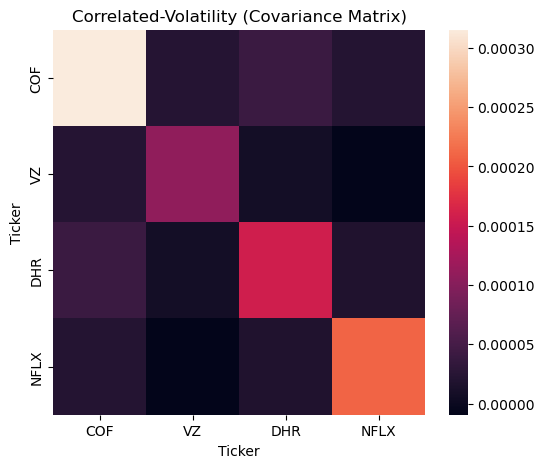

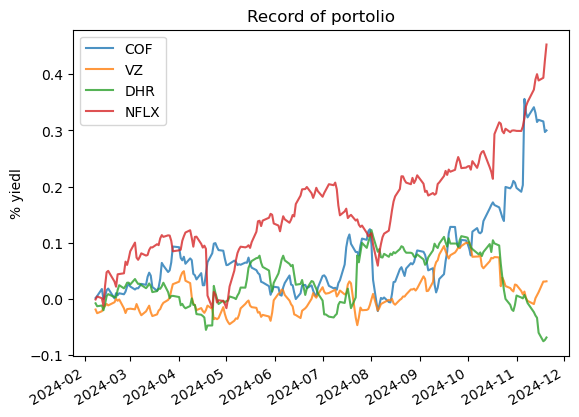

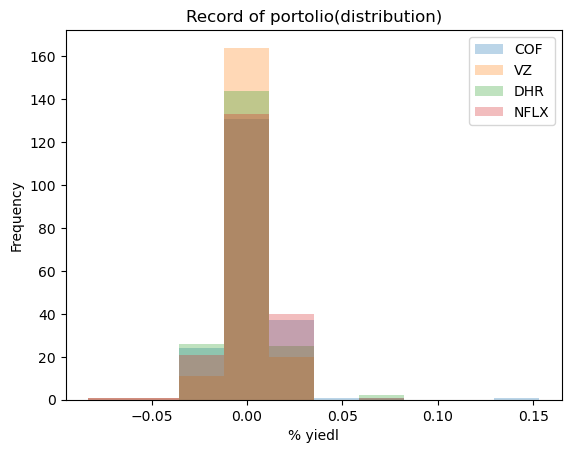

COF : mean=1.5220e-03, var=3.1523e-04, skewness=3.041
VZ : mean=1.6029e-04, var=1.0832e-04, skewness=-1.694
DHR : mean=-3.4701e-04, var=1.5789e-04, skewness=1.731
NFLX : mean=2.2979e-03, var=2.0965e-04, skewness=-0.341


In [20]:
def track_record(your_list):
    ticker = list(your_list.keys())

    print(ticker)
    Covarian_matrix = Test[ticker].cov()
    plt.figure(figsize=(6, 5))
    heatmap = sns.heatmap(Covarian_matrix, annot=False, fmt=".2e", annot_kws={"size": 9},cbar=True)
    plt.title('Correlated-Volatility (Covariance Matrix)')
    plt.show()

    Test[ticker].cumsum().plot(label=ticker,ylabel="% yiedl",title="Record of portolio", alpha =0.8)
    plt.legend()
    plt.show()

    mean = Test[ticker].mean()
    variance = Test[ticker].var()
    skewness = Test[ticker].skew()

    Test[ticker].plot.hist(label=ticker,xlabel="% yiedl",title="Record of portolio(distribution)",bins=10, alpha =0.3)
    plt.legend()
    plt.show()
    for i in range(len(ticker)):
        print(f"{ticker[i]} : mean={mean.values[i]:.4e}, var={variance.values[i]:.4e}, skewness={skewness.values[i]:.3f}" )


track_record(Buy_list_Sortino_ratio)

In [21]:
def How_much_money_I_need_now(your_list,simple=False):
    ticker = sorted(list(your_list.keys()))
    start_date = valid_end_day  - datetime.timedelta(days=1)
    Avg_price = Get_Average_price(ticker, start_date)
    n_stock = [1]*len(your_list)
    for i in range(len(ticker)):
        n_stock[i] = int(your_list[ticker[i]]*100)
    n_stock = np.array(n_stock)
    GCD = math.gcd(max(n_stock),min(n_stock))
    for i in range(len(n_stock)):
        GCD = math.gcd(GCD,n_stock[i])
    n_stock = n_stock/GCD
    prices = np.array(Avg_price.values[0])
    Need_Cash = sum(n_stock*prices)
    print("Full strategy:")
    print("Buy")
    for T, N in zip(ticker, n_stock):
        print(f"{N} stock of {T} at {Avg_price[T].values[0]:.2f}")
        print(f"portfolio weighting = {N*Avg_price[T].values[0]/Need_Cash*100} %")
        print("---------------------------------------------")
    print(f"Total cash needed is {Need_Cash:.2f} USD")
    print("=================================================")


    if simple:
        rounded_n_stock = np.array([float(round(x/10)) for x in n_stock])
        Need_Cash_simple = sum(rounded_n_stock*prices)
        print("Simple strategy:")
        print("Buy")
        for k in range(len(ticker)):
            print(f"{rounded_n_stock[k]} stock of {ticker[k]} at {Avg_price[ticker[k]].values[0]:.2f}")
            print(f"portfolio weighting = {rounded_n_stock[k]*Avg_price[ticker[k]].values[0]/Need_Cash_simple*100} %")
            print("------------------------------------------------")
        print(f"Total cash(Simple) needed is {Need_Cash_simple:.2f} USD")
    
How_much_money_I_need_now(Buy_list_Sortino_ratio)

[*********************100%%**********************]  4 of 4 completed

Removing ticker with nan values
Calculating average price
Full strategy:
Buy
10.0 stock of COF at 182.31
portfolio weighting = 11.542926663212368 %
---------------------------------------------
20.0 stock of DHR at 233.63
portfolio weighting = 29.585615376494722 %
---------------------------------------------
10.0 stock of NFLX at 891.66
portfolio weighting = 56.457007338957446 %
---------------------------------------------
9.0 stock of VZ at 42.37
portfolio weighting = 2.4144506213354577 %
---------------------------------------------
Total cash needed is 15793.65 USD
